# **Pré-processamento AI Democracy**

---

O objetivo desse *notebook* é criar os métodos de pré-processamento de textos específicos para o AI Democracy. Desse modo é esperado reduzir o tamanho do vocabulário e simplificar formas lexicais, de modo que seja mais fácil para nossos modelos de *machine learning* abstrair *features* e informações relevantes das Atas do Diário da Assembléia da República (DAR) Portuguesa.

## Carregando Bibliotecas:

Vamos então fazer o *download* do `spaCy`, uma biblioteca com funções de PLN e baixar também o conjunto de dados `pt_core_news_lg-3.0.0` também do `spaCy`que irá nos ajudar futuramente.

Fora isso importaremos também as bibliotecas tradicionais.

In [1]:
!pip install -U spacy

  Using cached https://files.pythonhosted.org/packages/1b/d8/0361bbaf7a1ff56b44dca04dace54c82d63dad7475b7d25ea1baefafafb2/spacy-3.0.6-cp37-cp37m-manylinux2014_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/61/87/decceba68a0c6ca356ddcb6aea8b2500e71d9bc187f148aae19b747b7d3c/thinc-8.0.3-cp37-cp37m-manylinux2014_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/ca/fa/d43f31874e1f2a9633e4c025be310f2ce7a8350017579e9e837a62630a7e/pydantic-1.7.4-cp37-cp37m-manylinux2014_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/c3/84/dfdfc9f6f04f6b88207d96d9520b911e5fec0c67ff47a0dea31ab5429a1e/srsly-2.4.1-cp37-cp37m-manylinux2014_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/13/87/5991d87be8ed60beb172b4062dbafef18b32fa559635a8e2b633c2974f85/pathy-0.5.2-py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/9c/10/dbc1203a4b1367c7b02fddf08cb2981d9aa3e688d398f587cea0ab9e3bec/catalogue-2.0.4-py3-none-any.whl
  Using cac

In [2]:
import pandas as pd
import numpy as np
import re
import nltk
import collections
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
nltk.download('stopwords')
from bs4 import BeautifulSoup
import os
import pickle
import spacy

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [3]:
!python -m spacy download pt_core_news_lg

2021-05-22 15:46:53.759628: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
     |████████████████████████████████| 578.1MB 19kB/s 
✔ Download and installation successful
You can now load the package via spacy.load('pt_core_news_lg')


## Carregando Dados:

Carregando o *dataset* das atas.

In [4]:
minutes = pd.read_csv('atas_com_subject.csv')
minutes.drop('Unnamed: 0', axis=1, inplace=True)

# **Limpeza "Bruta"**

---

Nesse primeiro módulo temos 3 funções cada uma tem um propósito e, combinadas, vão nos ajudar a limpar os dados na base da "força bruta". Dentro das Atas existem alguns erros de digitação que podem atrapalhar, criando variações de vocabulário inexistentes e gerando *tokens* que não são relevantes para o nosso trabalho.
<br><br>
`find_typos`: Serve para identificar *typos*, que são prováveis erros de digitação que a redação das Atas do DAR cometeu. Para conseguirmos acharmos quais são os prováveis *typos* usaremos a distância de edição de Levenshtein, essa distância retorna o número mínimo de operações necessárias para transformar uma `string` em outra. (Observação:  São consideradas operações a inserção, deleção ou substituição de um caractere.)
<br><br>
`clean`: Depois que os possíveis *typos* foram analisados manualmente e foi conferido quais realmente são os erros de digitação existentes, essa função cuida da parte de corrigir nosso *dataset* e substituir esses erros de digitação pela palavra correta.
<br><br>
`remove_non_politicians_party`: Essa função visa corrigir um problema na hora da coleta de dados, alguns cargos do DAR não possuem um partido explícito em suas falas, para o caso de Presidentes e Secretários, o algoritmo então erroneamente assimilava o Nome dessa pessoa ao local designado para o partido. Essa função deixa esses cargos sem esse partido.

In [5]:
def find_typos(citations, threshold=3):
    people = pd.Series(citations['Person'].unique()).to_list()
    people = list(set(people))

    tested = []
    k = 0

    for person_1 in people:
        for person_2 in people:
            is_different = person_1 != person_2
            not_tested = (person_1, person_2) not in tested
            edit_threshold = nltk.edit_distance(person_1, person_2) <= threshold
            if is_different and not_tested and edit_threshold:
                tested.append((person_1, person_2))
                tested.append((person_2, person_1))
                k+=1
                if k < 10:
                    print(' {}) '.format(k), person_1, '.'*(35 - len(person_1)), person_2)
                else:
                    print( '{}) '.format(k), person_1, '.'*(35 - len(person_1)), person_2)

def remove_non_politicians_party(citations):
    not_politicians = ['Presidente', 'Secretária', 'Secretário', 'Ministra', 'Ministro']
    for not_politician in not_politicians:
        citations['Party'].loc[citations['Person'].str.contains(not_politician)] = np.nan
    return citations

def clean(citations):
    #Corrigir falhas incoerências
    citations.replace(to_replace='Partido Socialista', value='PS', inplace=True)
    citations.replace(to_replace='SD', value=np.nan, inplace=True)
    citations.replace(to_replace='N insc.', value=np.nan, inplace=True)

    #Arrumando nomes que não tinham o devido espaçamento
    regex = re.compile("[a-zá-ú][A-Z]")
    for i in range(3):
        for person in citations['Person']:
            match = re.search(regex, person)
            if match:
                citations['Person'].replace(to_replace=person,
                                            value=person[:match.start()+1] + " " + person[match.end()-1:],
                                            inplace=True)
    for col in ['Person', 'Text']:
        citations[col].replace(to_replace='Rosário Gamboa', value='Rosário Gambôa', inplace=True)
        citations[col].replace(to_replace='António Malo de Abreu', value='António Maló de Abreu', inplace=True)
        citations[col].replace(to_replace='Inês de Sousa Leal', value='Inês de Sousa Real', inplace=True)
        citations[col].replace(to_replace='Vera Brás', value='Vera Braz', inplace=True)
        citations[col].replace(to_replace='Nélson Basílio Silva', value='Nelson Basílio Silva', inplace=True)
        citations[col].replace(to_replace='André Pinotes Baptista', value='André Pinotes Batista', inplace=True)
        citations[col].replace(to_replace='Claúdia Santos', value='Cláudia Santos', inplace=True)
        citations[col].replace(to_replace='Secretáriode Estado do Comércio, Serviços e Defesa do Consumidor',
                               value='Secretário de Estado do Comércio, Serviços e Defesa do Consumidor', inplace=True)
        citations[col].replace(to_replace='Secretáriade Estado da Habitação',
                               value='Secretária de Estado da Habitação', inplace=True)
        citations[col].replace(to_replace='Maria Antónia Almeida Santos',
                               value='Maria Antónia de Almeida Santos', inplace=True)

    return citations

print("="*30, "SEM LIMPEZA", "="*30)
find_typos(minutes)
print("\n\n")

print("="*30, "COM LIMPEZA", "="*30)
minutes = clean(minutes)
find_typos(minutes)
minutes = remove_non_politicians_party(minutes)

============================== SEM LIMPEZA ==============================
 1)  AndréSilva ......................... André Silva
 2)  AntónioFilipe ...................... António Filipe
 3)  Ministrada Modernização do Estado e da Administração Pública  Ministra da Modernização do Estado e da Administração Pública
 4)  António Lima Costa ................. AntónioLima Costa
 5)  Maria Antónia de Almeida Santos .... Maria Antónia Almeida Santos
 6)  André Pinotes Baptista ............. André Pinotes Batista
 7)  António Malo de Abreu .............. António Maló de Abreu
 8)  Rosário Gambôa ..................... Rosário Gamboa
 9)  Vera Braz .......................... Vera Brás
10)  IvanGonçalves ...................... Ivan Gonçalves
11)  Hugo Carvalho ...................... Nuno Carvalho
12)  Isabel Lopes ....................... Isabel Pires
13)  PedroDelgadoAlves .................. Pedro Delgado Alves
14)  Isabel Rodrigues ................... Anabela Rodrigues
15)  Paulo Porto ...........

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


# **Tokenização**

---

Nessa etapa queremos separar cada uma das palavras que temos do nosso texto, isso é um processo importante e quase obrigatório na maioria dos *pipelines* de PLN. Essa tratativa irá facilitar os nossos próximos pré-processamentos. Ao final queremos ter uma lista de *tokens*, ou seja, uma lista com cada uma dessas palavras.

`recover_citations_by_minute`: Função auxiliar que concatena todos os trechos de `minutes['Text']` para cada uma das Atas do DAR e devolve em forma de lista.
<br><br>
`recover_all_citations`: Concatena cada um dos textos da lista produzida pela função anterior, devolvendo um único bloco de texto.
<br><br>
`tokenization`: Função recebe um bloco de texto e aplica uma primeira limpeza, removendo sinais de pontuação e símbolos. Em seguida ela divide as palavras nos espaçamentos e cria os *tokens*. Vale ressaltar que essa função é sensível aos nomes dos políticos e nomes de partidos, ou seja, ela não divide um nome composto em dois *tokens* diferentes. Exemplo:<br>
Tokenização padrão: `'José Silva' --> ['José', 'Silva']`<br>
Tokenização sensível: `'José Silva' --> ['José Silva']`

In [6]:
def recover_citations_by_minute(citations):
    documents = []

    for transcript in citations['Transcript'].unique().tolist():
        concatenate = ''
        for text in citations['Text'].loc[citations['Transcript'] == transcript]:
            concatenate += text + ' '
        documents.append(concatenate)

    return documents

def recover_all_citations(citations):
    documents = recover_citations_by_minute(citations)

    text_all = ''
    for text in documents:
        text_all += text + ' '
    
    return text_all

def tokenization(text):
    chars_to_remove = "!\"#$%&'()*+,¸./:;<=>?@[\]^_`{|}-–⎯—«»´°‘’…~ªº€0123456789"
    for char in chars_to_remove:
        text = text.replace(char, ' ')
    text = text.replace('CDS PP', 'CDS-PP')

    #Passando pessoas e partidos para um único token concatenado
    person_map = {}
    for person in pd.Series(minutes['Person'].unique()).to_list():
        person_map[''.join(person.lower().split())] = person

    party_map = {}
    for party in pd.Series(minutes['Party'].unique()).to_list():
        party = str(party)
        party_map[''.join(party.lower().split())] = party

    #Aplicando token único no texto
    for person in person_map:
        text = text.replace(person_map[person], person)
    for party in party_map:
        party = str(party)
        text = text.replace(party_map[party], party)

    #Colocando todo o texto em lowercase e separando palavras
    text = text.lower()
    words = text.split()

    #Deixando nomes de pessoas como tokens legiveis novamente
    for i, word in enumerate(words):
        if word in person_map:
            words[i] = person_map[word]
        elif word in party_map:
            words[i] = party_map[word]

    return words

tokens = tokenization(recover_all_citations(minutes))
minutes['Tokenized_Text'] = minutes['Text'].apply(tokenization)

# **Lista de stopwords personalizada**

---

A proposta nessa etapa é filtrar as *stopwords* que existem no nosso vocabulário, entende-se por *stopword* palavras que são bastante frequentes em uma língua, mas que carregam pouca relevância semância, como exemplo artigos (“o” ou “uma”) e preposições (“de”) geralmente são *stopwords*. Para a filtragem vamos utilizar não só uma lista de *stopwords* para português do `NLTK` como também selecionaremos algumas palavras específicas que são *stopwords* no nosso contexto utilizando a Lei de Zipf.

`create_zipf_table`: Essa função irá retornar uma tabela de dados na forma de `pd.DataFrame` contendo a uma palavra (word), o número de vezes que essa palavra apareceu (frequency) e o ranque dessa palavra (rank).
<br><br>
`objective`: Função auxiliar para traçar a curva $f(x) = \frac{c}{x}$
<br><br>
`show_zipf_graph`: Está função gera um gráfico da frequência pelo rank de cada palavra usando a tabela gerada pela função anterior, estimando $c$ com um *fitting* dos dados.
<br><br>


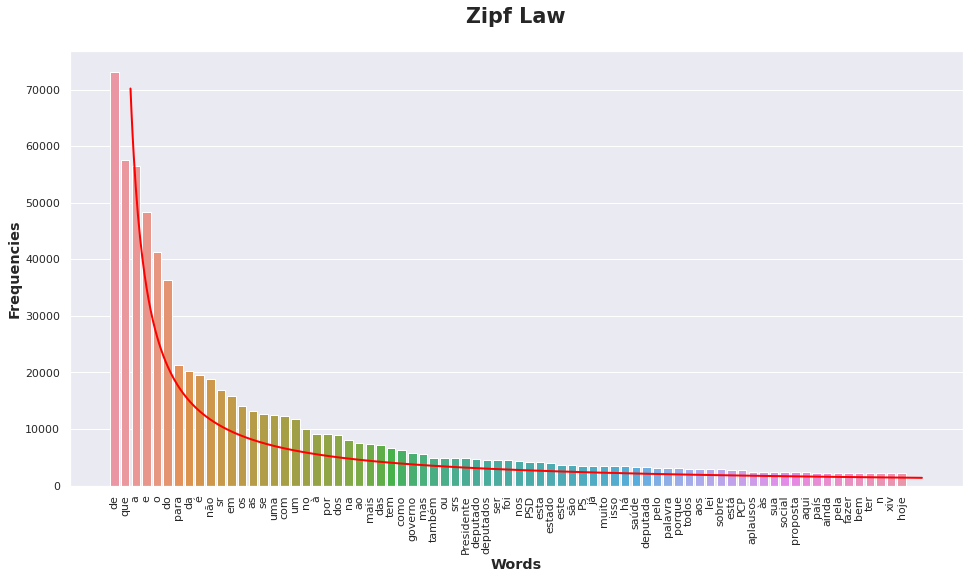

In [7]:
def create_zipf_table(words, top='all'):
    if top == 'all':
        frequencies = collections.Counter(words).most_common()
    if top != 'all':
        frequencies = collections.Counter(words).most_common(top)

    zipf_table = []

    top_frequency = frequencies[0][1]

    for index, item in enumerate(frequencies, start=1):
        zipf_table.append({
            "rank" : index,
            "word" : item[0],
            "frequency" : item[1],
        })

    return pd.DataFrame(zipf_table)

def objective (x, c):
    return c/x

def show_zipf_graph(words, top=50, with_tendency=True):
    df = create_zipf_table(words, top)

    sns.set(rc={'figure.figsize':(16,8)})
    ax = sns.barplot(x='word', y='frequency', data=df)
    ax.set_title('Zipf Law', fontsize='xx-large', fontweight='bold', y=1.05)
    ax.set_xlabel('Words', fontsize='large', fontweight='semibold')
    ax.set_ylabel('Frequencies', fontsize='large', fontweight='semibold')
    ax.tick_params(axis='x', rotation=90)

    if with_tendency:
        x = df['rank']
        y = df['frequency']

        c, _ = curve_fit(objective, x, y)

        math = pd.DataFrame()
        math['x'] = np.arange(1, len(create_zipf_table(words))+0.1, 0.1)
        math['f'] = c[0]/math['x']

        sns.lineplot(x='x', y='f', data=math[5:top*10], color='red', linewidth=2)
    
    plt.show()

show_zipf_graph(tokens, 75)

Podemos ver que as primeiras palavras que aparecem são as nossas *stopwords* "de sempre", vamos então remover elas utilziando a lista do `NLTK` para vermos se algumas palavras do nosso vocabulário se comportam como *stopwords*:

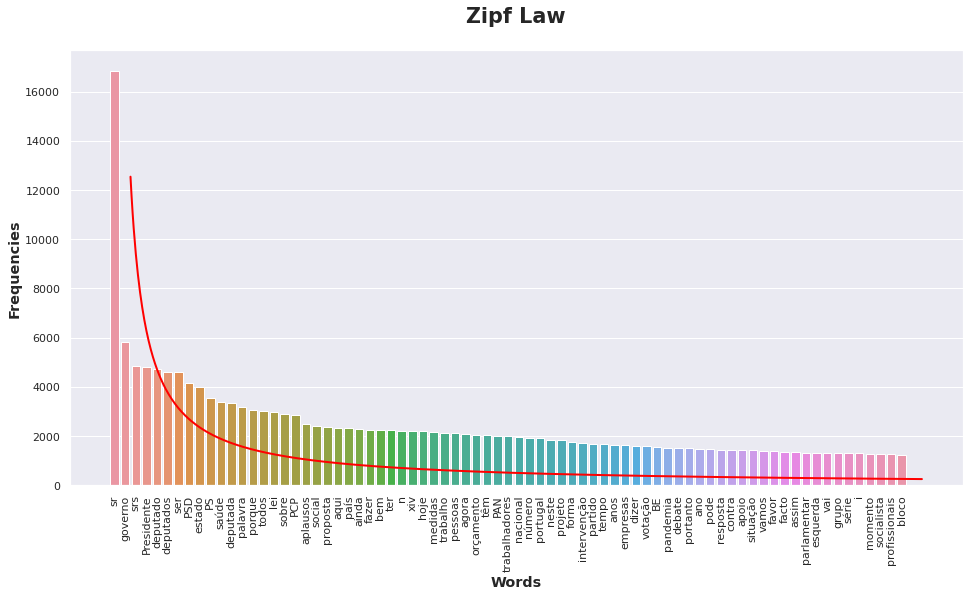

In [8]:
stopwords = nltk.corpus.stopwords.words('portuguese')
clean_words = [word for word in tokens if word not in stopwords]
zipf_table = create_zipf_table(clean_words)
show_zipf_graph(clean_words, 75, with_tendency=True)

Podemos perceber que a palavra "sr" tem um comportamento absurdamente discrepante dos outros, mas mesmo assim podemos perceber que as primeiras palavras até "deputados" apresentam muitas citação e não adicionam muito significado (para o nosso contexto específico), dessa forma vamos adicionar essas palavras à nossa lista de *stopwords* personalizada.

Como uma forma também de simplificar o nosso vocabulário é interessante remover as palavras que aparecem uma única vez, elas não agregam muito no sentido de que tem muito poucas aparições e dificultam a extração de *features* realmente relevantes. Vamos olhar algumas estatísticas:

In [9]:
#@title 


print('1) Tamanho do Vocabulário .............................. ', len(zipf_table))
print('2) Média da frequência com todas as palavras ........... ', round(zipf_table['frequency'].mean()))
print('3) Quantidade de palavras com 1 citação ................ ', len(zipf_table.loc[zipf_table['frequency'] == 1]))
print('4) Porcentagem de palavras com 1 citação ............... ', str(round(len(zipf_table.loc[zipf_table['frequency'] == 1])/len(zipf_table), 4)*100)+'%')
print('5) Média da frequência sem palavras únicas ............. ', round(zipf_table['frequency'].loc[zipf_table['frequency'] != 1].mean()))
print('6) Quantidade de palavras com mais de 3500 citações .... ', len(zipf_table.loc[zipf_table['frequency'] >= 3500]))
print('7) Porcentagem de palavras com mais de 3500 citações ... ', str(round(len(zipf_table.loc[zipf_table['frequency'] >= 3500])/len(zipf_table), 4)*100)+'%')

zipf_table.head(6)

1) Tamanho do Vocabulário ..............................  30956
2) Média da frequência com todas as palavras ...........  26
3) Quantidade de palavras com 1 citação ................  11208
4) Porcentagem de palavras com 1 citação ...............  36.21%
5) Média da frequência sem palavras únicas .............  40
6) Quantidade de palavras com mais de 3500 citações ....  10
7) Porcentagem de palavras com mais de 3500 citações ...  0.03%


,rank,word,frequency
0,1,sr,16839
1,2,governo,5814
2,3,srs,4851
3,4,Presidente,4811
4,5,deputado,4718
5,6,deputados,4617


Vamos criar então nossa lista de *stopwords* personalizada e filtrar os nossos *tokens*, não podemos esquecer de fazer esse processo também com o nosso *dataset*, vamos ainda usar essa parte para incluir algumas correções para algumas falhas que surgiram no processo de *tokenização*, por exemplo temos um *token* `n` com uma quantidade razoável de aparições que provavelmente surgiu após removermos o símbolo em `n°`.

`create_stopwordslist`: Função serve apenas para carregar as *stopwords* personalizadas e organizar em que parte do código isso está sendo feito.
<br><br>
`clean_my_tokens`: Está função pega apenas os *tokens* que não estão na lista de *stopwords*, vale ressaltar que como essa função demora um tempo considerável para rodar foi criado um arquivo de *checkpoint*, então o programa vai sempre tentar carregar esse arquivo feito (muito mais rápido) caso esse arquivo exista.

In [10]:
def create_stopwordslist(zipf_table):
    # Palavras com apenas 1 aparição
    frequency_1_tokens = list(set(zipf_table['word'].loc[zipf_table['frequency'] == 1].to_list()))

    # Tokens com apenas 1 caractere
    len_1_tokens = ['t', 's', 'á', 'l', 'v', 'm', 'p', 'b', '¾', 'g', 'n', 'i', 'h', 'f', 'x', 'r', 'ó', 'c', 'd']

    # Lista de Stopwords customizada
    custom_stopwords = [
        'sr',
        'sra',
        'srs',
        'sras',
        'ser',
        'governo',
        'estado',
        'deputado',
        'deputada',
        'deputados',
        'deputadas',
        'Presidente',
        'presidente',
        'xiv',
    ]

    new_stopwords = frequency_1_tokens + len_1_tokens + custom_stopwords

    return new_stopwords

def clean_my_tokens(tokens, stopwords):
    #Checa se tem o arquivo de tokens limpos
    if os.path.isfile('clean_tokens.pkl'):
        with open('clean_tokens.pkl', 'rb') as f:
            clean_tokens = pickle.load(f)
    #Limpa os tokens e salva em arquivo --> Demorado
    else:
        clean_tokens = [w for w in clean_words if w not in stopwords]
        with open('clean_tokens.pkl', 'wb') as f:
            pickle.dump(clean_tokens, f)
    
    return clean_tokens

def clean_my_df(df_tokens, stopwords=nltk.corpus.stopwords.words('portuguese')+create_stopwordslist(zipf_table)):
    return [token for token in df_tokens if token not in stopwords]

def load_clean_df(citations, stopwords):
    if os.path.isfile('clean_df.pkl'):
        with open('clean_df.pkl', 'rb') as f:
            citations = pickle.load(f)
    #Limpa os tokens e salva em arquivo --> Demorado
    else:
        citations['Clean_Tokens'] = citations['Tokenized_Text'].apply(clean_my_df)
        with open('clean_df.pkl', 'wb') as f:
            pickle.dump(citations, f)
    return citations

new_stopwords = create_stopwordslist(zipf_table)
clean_tokens = clean_my_tokens(clean_words, new_stopwords)
minutes = load_clean_df(minutes, stopwords+new_stopwords)

# **Lematização**

---

Essa etapa se trata de uma simplificação lexical do texto, as palavras se apresentam em diversas formas diferentes em flexões de gênero, número e tempo; nesse sentido a lematização entra para aglutinar várias dessas formas em um único *token* que corresponde ao modo infinitivo no caso de verbos e do masculino singular para o caso de substantivos e adjetivos.

Para isso usaremos a biblioteca `spaCy` que contém uma função de lematizador para português:

`normalize_my_tokens`: Retorna os lemmas das palavras.


In [11]:
nlp = spacy.load('pt_core_news_lg', exclude=['attribute_ruler', 'tok2vec', 'morphologizer',
                                             'parser', 'senter', 'ner', 'attribute_ruler'])

nlp.max_length = 6136000

def normalize_my_tokens(clean_tokens):
    if os.path.isfile('normalized_tokens.pkl'):
        with open('normalized_tokens.pkl', 'rb') as f:
            normalized_tokens = pickle.load(f)

    else:
        meaningful_string = ' '.join(clean_tokens)
        spacy_object = nlp(meaningful_string)
        normalized_tokens = [token.lemma_ for token in spacy_object]
        with open('normalized_tokens.pkl', 'wb') as f:
            pickle.dump(normalized_tokens, f)
    
    return normalized_tokens

def normalize_my_df(df_tokens):
    meaningful_string = ' '.join(df_tokens)
    spacy_object = nlp(meaningful_string)
    normalized_tokens = [token.lemma_ for token in spacy_object]
    return normalized_tokens

def load_normalized_df(citations):
    if os.path.isfile('normalized_df.pkl'):
        with open('normalized_df.pkl', 'rb') as f:
            citations = pickle.load(f)
    else:
        citations['Normalized_Tokens'] = citations['Clean_Tokens'].apply(normalize_my_df)
        with open('normalized_df.pkl', 'wb') as f:
            pickle.dump(citations, f)
    return citations
  
normalized_tokens = normalize_my_tokens(clean_tokens)
minutes = load_normalized_df(minutes)

---
---
---
---
---

# Doc2Vec

Nessa etapa vamos fazer o Embedding, não de palavras mas de toda uma fala 

--> Melhorar

In [12]:
len(set(normalized_tokens))

9637

In [13]:
rank = create_zipf_table(normalized_tokens)
rank.head(20)

,rank,word,frequency
0,1,fazer,6059
1,2,poder,5885
2,3,todo,5378
3,4,ter,5288
4,5,dizer,4626
5,6,dar,4525
6,7,ir,4439
7,8,PSD,4153
8,9,saudar,3702
9,10,PS,3563


In [14]:
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.models import Word2Vec

def create_word2vec_model(df, vector_size=100, window_size=5):
    sentences = []
    for i in range(len(df)):
        sentences.append(df['Normalized_Tokens'][i])
    
    model = Word2Vec(
        sentences=sentences,
        size=vector_size,
        window=window_size
        )
    
    return model

def create_doc2vec_model(df, vector_size=20, window_size=2):
    sentences = []
    for i in range(len(df)):
        sentences.append(df['Normalized_Tokens'][i])

    documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(sentences)]
    model = Doc2Vec(
        documents=documents,
        vector_size=vector_size,
        window=window_size,
    )

    return model

doc2vec = create_doc2vec_model(minutes)

In [15]:
vectors = []
for i in range(len(minutes)):
    vectors.append(doc2vec.infer_vector(minutes['Normalized_Tokens'][i]))

minutes['Vectors'] = pd.Series(vectors)

In [16]:
minutes.head()

,Transcript,Date,Position,Person,Party,Text,Subject,Tokenized_Text,Clean_Tokens,Normalized_Tokens,Vectors
0,DAR-001,17 DE SETEMBRO DE 2020,0,Presidente,NaN,Dirijo um abraço a todos neste regresso dos Pl...,declarações políticas 1,"[dirijo, um, abraço, a, todos, neste, regresso...","[dirijo, abraço, todos, neste, regresso, plená...","[dirigir, abraçar, todo, neste, regressar, ple...","[0.121852405, -0.26421618, -0.21224824, 0.0180..."
1,DAR-001,17 DE SETEMBRO DE 2020,1,Secretária,NaN,"Sr. Presidente, muito boa tarde a todas e a to...",declarações políticas 1,"[sr, Presidente, muito, boa, tarde, a, todas, ...","[boa, tarde, todas, todos, deram, entrada, mes...","[bom, tardar, todo, todo, dar, entrar, mesa, a...","[-0.013632625, -0.20226839, 0.029344337, 0.027..."
2,DAR-001,17 DE SETEMBRO DE 2020,2,Presidente,NaN,"Como os Srs. Deputados estão a verificar, o an...",declarações políticas 1,"[como, os, srs, deputados, estão, a, verificar...","[verificar, anúncio, expediente, segue, regras...","[verificar, anúncio, expediente, seguir, regra...","[0.09765393, -0.15307216, -0.14467825, 0.00487..."
3,DAR-001,17 DE SETEMBRO DE 2020,3,Secretária,NaN,"Sr. Presidente, deram também entrada os Projet...",declarações políticas 1,"[sr, Presidente, deram, também, entrada, os, p...","[deram, entrada, projetos, lei, IL, BE, BE, in...","[dar, entrar, projetos, lei, IL, BE, BE, inscr...","[0.039120924, -0.21613131, -0.07539723, -0.026..."
4,DAR-001,17 DE SETEMBRO DE 2020,4,Presidente,NaN,"Muito obrigado, Sr.ª Secretária Maria da Luz R...",declarações políticas 2,"[muito, obrigado, sr, Secretária, Maria da Luz...","[obrigado, Secretária, Maria da Luz Rosinha, p...","[obrigar, Secretária, Maria, da, Luz, Rosinha,...","[0.02291869, -0.24793299, -0.07499478, 0.02507..."


In [17]:
print('Original: ....... ', minutes['Text'][0], '\n')
print('Tokens: ......... ', minutes['Tokenized_Text'][0], '\n')
print('Clean Tokens: ... ', minutes['Clean_Tokens'][0], '\n')
print('Normalized: ..... ', minutes['Normalized_Tokens'][0], '\n')
print('Vectors: ........ ', minutes['Vectors'][0], '\n')


Original: .......  Dirijo um abraço a todos neste regresso dos Plenários à Casa da democracia. Esperávamos que nesta altura já pudéssemos ter regras mais flexíveis, mas, infelizmente, os números e as consequências concretas não nos permitem tal, e, portanto, continuamos, no essencial, com as regras que presidiram aos últimos Plenários da 1.ª Sessão Legislativa. Srs. Deputados, da nossa ordem do dia constam declarações políticas. Porém, antes disso, a Sr.ª Secretária Maria da Luz Rosinha fará o favor de anunciar a entrada de algumas iniciativas. Tem a palavra, Sr.ª Secretária. 

Tokens: .........  ['dirijo', 'um', 'abraço', 'a', 'todos', 'neste', 'regresso', 'dos', 'plenários', 'à', 'casa', 'da', 'democracia', 'esperávamos', 'que', 'nesta', 'altura', 'já', 'pudéssemos', 'ter', 'regras', 'mais', 'flexíveis', 'mas', 'infelizmente', 'os', 'números', 'e', 'as', 'consequências', 'concretas', 'não', 'nos', 'permitem', 'tal', 'e', 'portanto', 'continuamos', 'no', 'essencial', 'com', 'as', 'reg

In [19]:
with open('Vectorized_Dataframe.pkl', 'wb') as f:
    pickle.dump(minutes, f)